In [117]:
import os
import re
import string
import random
import pandas as pd
import operator
import matplotlib.pylab as plt
import warnings
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from nltk.tokenize import word_tokenize

warnings.filterwarnings(action="ignore")
%matplotlib inline

Создадим несколько переменных для того, чтобы составить материальню базу.

**folds** – Это список папок, в которых хранятся наши тектсы, с которыми мы будем работать.

**txts** – Список, в который мы поместим все наши тексты после обработки.

**dir_line** – путь до нашей рабочей директори

In [118]:
folds = ['Friends - season 1', 'Friends - season 2', 'Friends - season 3',
         'Friends - season 4', 'Friends - season 5', 'Friends - season 6',
         'Friends - season 7']

txts = []

Добавим функцию, которая будет чистить текст от всякой гадости.

    1.Для очистки от знаков использую *string.punctuation*

    2.Помимо этого в тексте есть и другия грязь, от которой необходимо избавиться.

    3.Выполняю токенизацию текста и склеиваю все в один текст, *исключая числа*.

In [119]:
def cleaning(text):
    tokens = word_tokenize(text.lower())
    for el in tokens:
        if el in string.punctuation:
            tokens.remove(el)
        if el == '...' or el == "''" or el == '—' or el == '«' or el == '»':
            tokens.remove(el)
    text = ' '.join([i for i in tokens if not i.isdigit()])
    return(text)

Пройдемся по папкам и достанем все текста. Обработаем его и добавим в список.

In [120]:
text_num = 0
names = defaultdict()
for fold in folds:
    local_dir = list(os.walk(os.path.abspath(fold)))
    local_path = str(local_dir[0][0])
    for text in local_dir[0][2]:
        if '.txt' in text and type(text) == str:
            with open(local_path + '/' + text) as file:
                txts.append(cleaning(file.read()))
                names[text_num] = text
                text_num += 1

Для составления терм-документ матрицы я использую ***CountVectorizer*** из *sklearn.feature_extraction.text*

Тем самым составлю матрицу, где:

    Столбцы – Это слова
    Строки – Это документы

Для удобства также преобразую матрицу в **DataFrame** при помощи Pandas

In [121]:
vec = CountVectorizer()
TDM = vec.fit_transform(txts).toarray()
TDM_DataFrame = pd.DataFrame(TDM,
                             columns=vec.get_feature_names())

In [122]:
TDM_DataFrame.shape

(165, 30829)

Теперь переименум индексы фрейма в названия файлов, которые мы создали при обработке текста, чтобы сделать более информативную выдачу результата.

In [123]:
TDM_DataFrame = TDM_DataFrame.rename(index=names)

In [125]:
TDM_DataFrame.shape

(165, 30829)

Получается 165 документов и 30829 слов.

Напишем простую функцию Булева поиска, которая может искать только одно слово.

Как я и говорил раньше, всвязи с форматом матрицы, необходимо только найти такие строки, в столбце соответсвующем патерну поиска стоит НЕ ноль.

In [126]:
def boolean_search(pattern):
    try:
        return TDM_DataFrame[TDM_DataFrame[pattern.lower()] != 0].index.tolist()
    except KeyError:
        return 'No pattern in DataSet'

Теперь можно посмотреть на индексы файлов, в которых встречатеся (Первые 10, для сокращения выдачи)

In [129]:
boolean_search('Рейчел')[:10]

['Friends - 2x02 - The One With The Breast Milk.ru.txt',
 "Friends - 2x04 - The One With Phoebe's Husband.ru.txt",
 'Friends - 2x05 - The One With Five Steaks And An Eggplant.ru.txt',
 'Friends - 2x07 - The One Where Ross Finds Out.ru.txt',
 "Friends - 2x09 - The One With Phoebe's Dad.ru.txt",
 'Friends - 2x10 - The One With Russ.ru.txt',
 'Friends - 2x12 - The One After The Super Bowl (1).ru.txt',
 'Friends - 2x13 - The One After The Super Bowl (2).ru.txt',
 'Friends - 2x14 - The One With The Prom Video.ru.txt',
 'Friends - 2x15 - The One Where Ross And Rachel...You Know.ru.txt']

In [130]:
boolean_search('Фиби')[:10]

['Friends - 1x01 - The One Where Monica Gets A Roommate.ru.txt',
 'Friends - 1x03 - The One With The Thumb.ru.txt',
 'Friends - 1x04 - The One With George Stephanopoulos.ru.txt',
 'Friends - 1x07 - The One With The Blackout.ru.txt',
 'Friends - 1x08 - The One Where Nana Dies Twice.ru.txt',
 'Friends - 1x09 - The One Where Underdog Gets Away.ru.txt',
 'Friends - 1x10 - The One With The Monkey.ru.txt',
 'Friends - 1x11 - The One With Mrs. Bing.ru.txt',
 'Friends - 1x12 - The One With The Dozen Lasagnas.ru.txt',
 'Friends - 1x13 - The One With The Boobies.ru.txt']

Вроде работает. Теперь займемся более сложным поиском.

Лоя этого, сперва напишем две фенкции, которые помогут нам взаимодействовать со строкой с параметрами поиска. Для этого нам необходимо.
    
    Вычетание списков "Для (Не pattern)" – Difference(line)
    Сумма списков "Для (pattern ИЛИ pattern)" – Union(line)
    
В этих функциях, я достаю слова, которые нам нобходжимо дость из файлов, нахожу список файлов, в которых встречаются эти слова, а затем выполняю необходимые мне файлы.

Для Вычетания применяю такой алгоритм:

    1. Получаю файлы ГДЕ ВСТРЕЧАЕТСЯ необходимое слово.
    2. Создаю список range от 1 до 165
    3. Вычитаю из списка (п.2) список (п.1), тем самым получаю файлы, в которых нет необходимого слова.
    

In [134]:
def Union(line):
    try:
        sub = re.search('\((.*?) ИЛИ (.*?)\)', line)
        result_1 = boolean_search(str(sub.group(1)))
        result_2 = boolean_search(str(sub.group(2)))
        return list(set.union(set(result_1),
                              set(result_2)))
    except AttributeError:
        return None
        
def Difference(line):
    try:
        sub = re.search('\(НЕ (.*?)\)', line)
        result_1 = boolean_search(str(sub.group(1)).lower())
        return list(set.difference(set(TDM_DataFrame.index.tolist()), set(result_1)))
    except AttributeError:
        return None

Основная функция поиска. Если в строке втречается необходимая мне фраза ("ИЛИ" или "НЕ"), то выполняю необходимую фунуцию для получения номеров файлов.

In [132]:
def boolean_search_type_r(pattern):
    try:
        local_pattern = pattern.split(' & ')
        local_result = []
        for el in local_pattern:
            if ' ИЛИ ' in el:
                local_result.append(Union(el))
            elif 'НЕ ' in el:
                local_result.append(Difference(el))
            else:
                local_result.append(boolean_search(el))
        return list(set.intersection(*map(set, local_result)))
    except KeyError:
        return 'No pattern in DataSet'

**Проверим работу нашего алгоритма**

In [140]:
boolean_search_type_r('(НЕ Моника)')

["Friends - 4x14 - The One With Joey's Dirty Day.ru.txt",
 'Friends - 3x06 - The One With The Flashback.ru.txt',
 'Friends - 4x15 - The One With All The Rugby.ru.txt',
 'Friends - 5x06 - The One With The Yeti.ru.txt',
 "Friends - 6x19 - The One With Joey's Fridge.ru.txt",
 'Friends - 1x16 - The One With Two Parts (1).ru.txt',
 'Friends - 7x09 - The One With All The Candy.ru.txt',
 'Friends - 2x12 - The One After The Super Bowl (1).ru.txt',
 "Friends - 7x02 - The One With Rachel's Book.ru.txt",
 'Friends - 1x20 - The One With The Evil Orthodontist.ru.txt',
 'Friends - 5x24-25 - The One In Vegas (2).ru.txt',
 "Friends - 6x14 - The One Where Chandler Can't Cry (2).ru.txt",
 'Friends - 4x17 - The One With The Free Porn.ru.txt',
 "Friends - 6x13 - The One With Rachel's Sister (1).ru.txt",
 "Friends - 2x19 - The One Where Eddie Won't Go.ru.txt",
 'Friends - 4x20 - The One With The Wedding Dresses.ru.txt',
 "Friends - 3x11 - The One Where Chandler Can't Remember Which Sister.ru.txt",
 "Friend

In [141]:
boolean_search_type_r('(машина ИЛИ консоль)')

["Friends - 7x08 - The One Where Chandler Doesn't Like Dogs.ru.txt",
 'Friends - 3x17 - The One Without The Ski Trip.ru.txt',
 'Friends - 6x01 - The One After Vegas.ru.txt',
 'Friends - 7x13 - The One Where Rosita Dies.ru.txt',
 'Friends - 5x20 - The One With The Ride Along.ru.txt',
 'Friends - 5x16 - The One With The Cop.ru.txt',
 "Friends - 7x22 - The One With Chandler's Dad.ru.txt",
 'Friends - 6x11 - The One With The Apothecary Table.ru.txt',
 'Friends - 7x14 - The One Where They All Turn Thirty.ru.txt',
 "Friends - 6x05 - The One With Joey's Porsche.ru.txt",
 "Friends - 2x19 - The One Where Eddie Won't Go.ru.txt",
 'Friends - 6x20 - The One With Mac And C.H.E.E.S.E..ru.txt',
 'Friends - 1x18 - The One With All The Poker.ru.txt',
 'Friends - 2x15 - The One Where Ross And Rachel...You Know.ru.txt',
 'Friends - 1x05 - The One With The East German Laundry Detergent.ru.txt',
 'Friends - 2x22 - The One With The Two Parties.ru.txt',
 'Friends - 3x07 - The One With The Race Car Bed.ru.txt

In [142]:
boolean_search_type_r('консоль')

['Friends - 6x11 - The One With The Apothecary Table.ru.txt']

In [143]:
boolean_search_type_r('машина')

['Friends - 6x01 - The One After Vegas.ru.txt',
 'Friends - 3x17 - The One Without The Ski Trip.ru.txt',
 "Friends - 7x08 - The One Where Chandler Doesn't Like Dogs.ru.txt",
 'Friends - 7x13 - The One Where Rosita Dies.ru.txt',
 'Friends - 5x16 - The One With The Cop.ru.txt',
 'Friends - 5x20 - The One With The Ride Along.ru.txt',
 "Friends - 7x22 - The One With Chandler's Dad.ru.txt",
 'Friends - 7x14 - The One Where They All Turn Thirty.ru.txt',
 "Friends - 6x05 - The One With Joey's Porsche.ru.txt",
 "Friends - 2x19 - The One Where Eddie Won't Go.ru.txt",
 'Friends - 6x20 - The One With Mac And C.H.E.E.S.E..ru.txt',
 'Friends - 1x18 - The One With All The Poker.ru.txt',
 'Friends - 2x15 - The One Where Ross And Rachel...You Know.ru.txt',
 'Friends - 1x05 - The One With The East German Laundry Detergent.ru.txt',
 'Friends - 2x22 - The One With The Two Parties.ru.txt',
 'Friends - 3x07 - The One With The Race Car Bed.ru.txt',
 'Friends - 1x11 - The One With Mrs. Bing.ru.txt',
 "Friend

In [144]:
len(boolean_search_type_r('консоль')) + len(boolean_search_type_r('машина')) == len(boolean_search_type_r('(машина ИЛИ консоль)'))

True

_________

# Теперь займемся обратным словарем

Для этого создадим новую функцию записи данных... Для этого задания нам понадобится список слов.

In [23]:
result = defaultdict()

def sharp_cleaning(text):
    tokens = word_tokenize(text.lower())
    for el in tokens:
        if el in string.punctuation:
            tokens.remove(el)
        if el == '...' or el == "''" or el == '—' or el == '«' or el == '»':
            tokens.remove(el)
    return(list([i for i in tokens if not i.isdigit()]))

Новый формат хранения будет выглядеть таким образом:

    Ключ – Слово
    Значение – Список пар [сезон х серия, количество вхождений]

In [145]:
result = defaultdict()

for fold in folds:
    local_dir = list(os.walk(os.path.abspath(fold)))
    local_path = str(local_dir[0][0])
    for text in local_dir[0][2]:
        if '.txt' in text and type(text) == str:
            with open(local_path + '/' + text) as file:
                local_text = sharp_cleaning(file.read())
                index = text.split(' - ')[1]
                for word in local_text:
                    if word in result:
                        if index in list(chain(*result[word])):
                            num = list(chain(*result[word])).index(index) // 2
                            result[word][num][1] += 1
                        else:
                            result[word].append([index, 1])
                    else:
                        result[word] = [[index, 1]]

Для проверки можно выыести наши словари, но я этого делать не буду, ибо выдача очень большая

In [146]:
#result

In [147]:
#result['рейчел']

Чтобы найти слово с максимальным и минимальным количеством вхождений, нам надо только найти ключ, которому соответсвует самый короткий и самый длинный список.

In [148]:
def max_word(diction):
    local_diction = defaultdict()
    for word in diction:
        local_diction[word] = sum(filter(lambda i: isinstance(i, int), list(chain(*diction[word]))))
    return max(local_diction, key=local_diction.get)

def min_word(diction):
    local_diction = defaultdict()
    for word in diction:
        local_diction[word] = sum(filter(lambda i: isinstance(i, int), list(chain(*diction[word]))))
    return min(local_diction, key=local_diction.get)

In [149]:
min_word(result)

'насорю'

In [150]:
max_word(result)

'я'

Чтобы найти слово, которое есть в каждом файле, нам необходимо найти ключ, длинна словаря которого == 165.

К сожалению такое слово я не нашел

In [153]:
for word in result:
    if len(result[word]) == 165:
        print(word)

Для каждого персонажа, посчитаем сколько раз его упомянали в каждом сезоне и составим bar chart...

In [154]:
def most_season(dude):
    local_result = {}
    data = result[dude.lower()]
    for el in data:
        if el[0].split('x')[0] in local_result:
            local_result[el[0].split('x')[0]] += el[1]
        else:
            local_result[el[0].split('x')[0]] = 1
    return local_result

In [155]:
def converting(dictionary):
    result = [0, 0, 0, 0, 0, 0, 0]
    for el in dictionary:
        result[int(el) - 1] = dictionary[el]
    return result

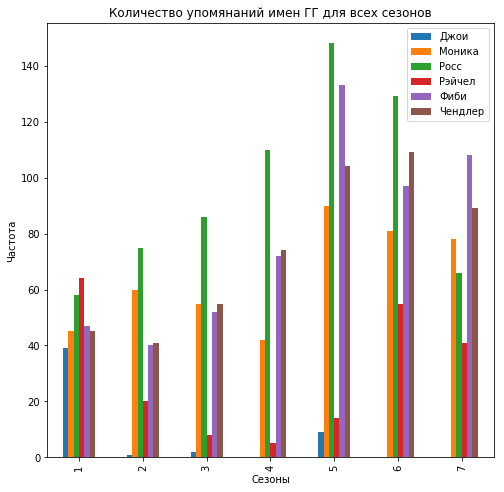

In [156]:
percentile_list = pd.DataFrame(
    {'Росс': converting(most_season('Росс')),
     'Джои': converting(most_season('Джои')),
     'Рэйчел': converting(most_season('Рэйчел')),
     'Фиби': converting(most_season('Фиби')),
     'Моника': converting(most_season('Моника')),
     'Чендлер': converting(most_season('Чендлер')),
    })

percentile_list.index += 1
percentile_list.plot.bar(figsize=(8, 8),
                         title='Количество упомянаний имен ГГ для всех сезонов',
                         legend=True)

plt.xlabel('Сезоны')
plt.ylabel('Частота')

____________

# Okapi25

Сперва, для решения этой задачи реализуем функцию, которую мы видели на семинаре с соответствующими переменными

In [157]:
from math import log

k1 = 2.0
b = 0.75

def score_BM25(qf, dl, avgdl, k1, b, N, n) -> float:
    IDF = log(((N - n + 0.5) / (n + 0.5)))
    first = (k1 + 1) * qf
    second = qf + (k1 * ((1-b) + b * (float(dl)/float(avgdl))))
    return IDF * (first / second)

Проверим работоспособность нашей функции на примере рандомных чисел.

In [158]:
score_BM25(1, 2, 14, k1, b, 3, 2)

-0.8939448415904836

Не ломается и хорошо...

Теперь, составим новый формат хранения данных, это нам поможет для осуществления быстрой работы ранжирования при дальнейшей работы алгоритма.

Сперва предствим нашу коллекцию ввиде словаря, где:

    Ключи – Название документа
    Значения – Список, который содержит частотный словарь для текста и количетсво слов.

In [159]:
folds = ['Friends - season 1', 'Friends - season 2', 'Friends - season 3',
         'Friends - season 4', 'Friends - season 5', 'Friends - season 6',
         'Friends - season 7']

documents = defaultdict()

dir_line = '/Users/macbook/Downloads/Friends/'

for fold in folds:
    local_dir = list(os.walk(os.path.abspath(fold)))
    local_path = str(local_dir[0][0])
    for text in local_dir[0][2]:
        if '.txt' in text and type(text) == str:
            with open(local_path + '/' + text) as file:
                text_list, text_data = sharp_cleaning(file.read()), defaultdict()
                for word in text_list:
                    if not word in text_data:
                        text_data[word] = 0
                    text_data[word] += 1
                documents[str(text)] = [text_data, len(text_list)]

Выведем данные для рандомного текста нашей коллекции. (Нет, слишком длинный словарь...)

In [169]:
#documents[random.choice(list(documents.keys()))]

Чтобы получить количество текстов в коллекции, просто надо посмотреть на длинну нашего словаря

In [161]:
len(documents)

165

Чтобы посчитать среднюю длинну тектов коллекции, сложим все данные для каждого текста и поделим на длинну списка с длиннами.

In [162]:
def mean_doc_len(coll):
    result = []
    for doc in coll:
        result.append(int(coll[doc][1]))
    return sum(result) / float(len(result))

In [163]:
mean_doc_len(documents)

2023.7575757575758

Также для работы нашей формулы нам необходимо найти количество документов, где встречается слово из запроса.

In [164]:
def query_occurrence(query, coll):
    result = 0
    for doc in coll:
        if query.lower() in coll[doc][0]:
            result += 1
    return result

In [165]:
query_occurrence('Рэйчел', documents)

56

Теперь все готово к работе с нашей формулой!

In [166]:
def compute_sim(query, document):
    result = defaultdict()
    N = len(documents)
    avgdl = mean_doc_len(documents)
    k1 = 2.0
    b = 0.75
    n = query_occurrence(query, documents)
    dl = document[1]
    try:
        qf = document[0][str(query).lower()]
    except KeyError:
        qf = 0
    return score_BM25(qf, dl, avgdl, k1, b, N, n)


def get_search_result(query):
    result = {}
    words = query.split(' ')
    for document in documents:
        local_score = 0
        for word in words:
            local_score += compute_sim(word, documents[document])
        result[str(document)] = local_score
    return sorted(result.items(), key=lambda kv: kv[1], reverse=True)


Ура, теперь только проверим на выражении 'рождественские каникулы'

In [167]:
get_search_result('рождественские каникулы')[:10]

[("Friends - 6x19 - The One With Joey's Fridge.ru.txt", 6.62893145848959),
 ("Friends - 2x09 - The One With Phoebe's Dad.ru.txt", 6.490721263471384),
 ('Friends - 1x17 - The One With Two Parts (2).ru.txt', 5.452230363430965),
 ('Friends - 1x16 - The One With Two Parts (1).ru.txt', 5.39840804737953),
 ('Friends - 7x10 - The One With The Holiday Armadillo.ru.txt',
  3.855784061289655),
 ("Friends - 4x03 - The One With The 'Cuffs.ru.txt", 3.6340813790887228),
 ('Friends - 6x09 - The One Where Ross Got High.ru.txt', 3.6203441870433157),
 ('Friends - 7x05 - The One With The Engagement Picture.ru.txt', 0.0),
 ('Friends - 1x15 - The One With The Stoned Guy.ru.txt', 0.0),
 ('Friends - 6x04 - The One Where Joey Loses His Insurance.ru.txt', 0.0)]

Теперь у нас есть словарь, где каждому названию файла (ключ) соответсвует его score (значение).

Красиво выведем перые пять результатов.

In [168]:
query = 'Рождественские каникулы'

print('For query "%s" the algorithm finished working with top 10 result:\n' % (query))

for el in get_search_result(query)[:10]:
    print ('File name:\t%s\nOkapi25 score:\t%s.\n' % (str(el[0]), str(el[1])))

For query "Рождественские каникулы" the algorithm finished working with top 10 result:

File name:	Friends - 6x19 - The One With Joey's Fridge.ru.txt
Okapi25 score:	6.62893145848959.

File name:	Friends - 2x09 - The One With Phoebe's Dad.ru.txt
Okapi25 score:	6.490721263471384.

File name:	Friends - 1x17 - The One With Two Parts (2).ru.txt
Okapi25 score:	5.452230363430965.

File name:	Friends - 1x16 - The One With Two Parts (1).ru.txt
Okapi25 score:	5.39840804737953.

File name:	Friends - 7x10 - The One With The Holiday Armadillo.ru.txt
Okapi25 score:	3.855784061289655.

File name:	Friends - 4x03 - The One With The 'Cuffs.ru.txt
Okapi25 score:	3.6340813790887228.

File name:	Friends - 6x09 - The One Where Ross Got High.ru.txt
Okapi25 score:	3.6203441870433157.

File name:	Friends - 7x05 - The One With The Engagement Picture.ru.txt
Okapi25 score:	0.0.

File name:	Friends - 1x15 - The One With The Stoned Guy.ru.txt
Okapi25 score:	0.0.

File name:	Friends - 6x04 - The One Where Joey Loses